# Project 3 CBIR

姜海天 19307110022

## Task 1 自己实现 LSH 算法，并实现三种不同的距离度量所对应的哈希函数。(euclidean distance, Hamming distance, Cosine distance, Jaccard distance )

First I implemented the `BasicLSH` as a base class, because the only difference among different LSHs lies in the difference of the hash function, while constructing bins from the signature is exactly the same regardless of the hash function. Therefore, for the variations of LSH, I only need to implement how they sign the features and how to select the wanted contents based on the distance measurement in the second pass.

In [1]:
import numpy as np
from collections import defaultdict

class BasicLSH:
    def __init__(self, d_feat: int, d_sig: int, band: int):
        assert d_sig % band == 0
        self.d_feat = d_feat
        self.d_sig = d_sig
        self.band = band
        self.row = d_sig // band
        self.hash_tables = [defaultdict(set) for _ in range(band)]

    def get_hash_func(self):
        raise NotImplementedError

    def _sign(self, feature_vec: np.ndarray):
        raise NotImplementedError

    def distance(self, x: np.ndarray, y: np.ndarray):
        raise NotImplementedError

    def sign_samples(self, samples: np.ndarray):
        assert samples.ndim == 2
        assert samples.shape[0] == self.d_feat
        self.samples = samples
        self.n_samples = samples.shape[1]
        signature = np.zeros([self.d_sig, self.n_samples])
        for index in range(samples.shape[1]):
            signature[:, index] = self._sign(samples[:, index])
        return signature

    def hash_samples(self):
        for index in range(self.n_samples):
            for b in range(self.band):
                sig_vec = self.signature[:, index]
                sig_slot = sig_vec[b * self.row: (b + 1) * self.row]
                key = tuple(sig_slot.tolist())
                self.hash_tables[b][key].add(index)

    def encode(self, samples: np.ndarray):
        self.get_hash_func()
        self.signature = self.sign_samples(samples)
        self.hash_samples()

    def query(self, q: np.ndarray, top_k: int = 50):
        assert len(q) == self.d_feat
        q_sig = self._sign(q)
        hit_cnt, item_sim = defaultdict(int), {}
        for b in range(self.band):
            sig_slot = q_sig[b * self.row: (b + 1) * self.row]
            key = tuple(sig_slot.tolist())
            candidates = self.hash_tables[b][key]
            for index in candidates:
                hit_cnt[index] += 1
                if index not in item_sim:
                    distance = self.distance(q, self.samples[:, index])
                    item_sim[index] = distance
        return sorted(list(item_sim.items()), key=lambda x: x[1])[:top_k]

In [2]:
import random

class JaccardLSH(BasicLSH):
    def __init__(self, *args):
        super().__init__(*args)
    
    def get_hash_func(self):
        hash_functions = []
        for i in range(self.d_sig):
            perm = list(range(self.d_feat))
            random.shuffle(perm)
            hash_functions.append(perm)
        self.hash_functions = hash_functions
        
    def _sign(self, feature_vec: np.ndarray):
        # feature_vec should be 0/1 vector
        signature = np.zeros(self.d_sig)
        for sig_index, perm in enumerate(self.hash_functions):
            i = 0
            while feature_vec[perm[i]] == 0:
                i += 1
            signature[sig_index] = perm[i]
        return signature
    
    def distance(self, x: np.ndarray, y: np.ndarray):
        return 1-float(sum(x&y) / sum(x|y))

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

class CosineLSH(BasicLSH):
    def __init__(self, *args):
        super().__init__(*args)
    
    def get_hash_func(self):
        self.hash_functions = np.random.randn(self.d_sig, self.d_feat)
        
    def _sign(self, feature_vec: np.ndarray):
        return self.hash_functions @ feature_vec > 0
    
    def sign_samples(self, samples: np.ndarray):
        # override for faster calculation
        assert samples.ndim == 2
        assert samples.shape[0] == self.d_feat
        self.samples = samples
        self.n_samples = samples.shape[1]
        return self.hash_functions @ samples > 0
    
    def distance(self, x: np.ndarray, y: np.ndarray):
        return 1 - cosine_similarity(x.reshape(1,-1), y.reshape(1,-1))

In [27]:
from sklearn.preprocessing import normalize

class EuclideanLSH(BasicLSH):
    def __init__(self, *args):
        super().__init__(*args)
    
    def get_hash_func(self):
        hash_functions = np.random.randn(self.d_sig, self.d_feat)
        self.hash_functions = normalize(hash_functions, axis=0)
        
    def _sign(self, feature_vec: np.ndarray):
        return np.int8(self.hash_functions @ feature_vec)
    
    def distance(self, x: np.ndarray, y: np.ndarray):
        return np.linalg.norm(x-y)

## Task 2 假设此时的数据是`numpy`随机生成的1万个维度为48的数据(random seed=4), 有一个数据query(random seed=10), 利用上述的LSH算法找到最接近的50个向量。 计算这些向量和query之间的距离。（距离按照上述实现的三种不同的距离度量方式）

Only show the index of the retrieved vectors, for it would be too wordy to show all the distances. The result shows that three different methods retrieve similar results, especially for the higher ranked ones, they are the same for top 6.

In [4]:
np.random.seed(4)
data = np.random.randint(2, size=[48, 10000])
np.random.seed(10)
q=np.random.randint(2, size=48)

In [39]:
jaccard_lsh = JaccardLSH(48, 120, 24)
jaccard_lsh.encode(data)
result_j = jaccard_lsh.query(q)
index_j = [i[0] for i in result_j]
print("Retrieved index:", index_j)

Retrieved index: [3722, 4964, 1378, 9266, 3371, 8878, 7378, 4456, 9167, 9231, 1019, 3499, 4056, 1151, 3997, 8183, 4986, 8221, 4412, 7557, 3907, 2008, 5208, 2596, 4660, 5972, 6209, 1756, 2469, 5187, 3266, 9454, 580, 4727, 9106, 5101, 4383, 2409, 4726, 9366, 781, 380, 5408, 822, 7245, 3360, 1116, 635, 6535, 8602]


In [40]:
cosine_lsh = CosineLSH(48, 120, 24)
cosine_lsh.encode(data)
result_c = cosine_lsh.query(q)
index_c = [i[0] for i in result_c]
print("Retrieved index:", index_c)

Retrieved index: [3722, 4964, 1378, 9266, 3371, 8878, 4527, 7378, 4456, 8221, 8183, 4986, 9167, 8140, 4056, 3997, 1151, 1019, 8695, 9231, 3499, 2469, 1756, 6209, 5972, 4660, 4412, 1340, 8035, 2008, 5208, 7557, 8373, 2596, 3907, 9996, 5861, 3360, 1116, 4216, 4538, 6535, 8602, 635, 6980, 3524, 5187, 4727, 2244, 4726]


In [41]:
euclidean_lsh = CosineLSH(48, 120, 24)
euclidean_lsh.encode(data)
result_e = euclidean_lsh.query(q)
index_e = [i[0] for i in result_e]
print("Retrieved index:", index_e)

Retrieved index: [3722, 4964, 1378, 9266, 3371, 8878, 4456, 4527, 7378, 8221, 8183, 4986, 9167, 8140, 1151, 3997, 4056, 9231, 3499, 1019, 8695, 2469, 1756, 4660, 5972, 6209, 4412, 1340, 8035, 3907, 8373, 2596, 2008, 5208, 7557, 9996, 5861, 635, 1116, 8602, 3360, 4538, 6535, 4216, 3524, 6980, 5187, 781, 822, 9106]


## Task 3 对2求得的50个向量以及query利用合适的方式可视化结果

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(init='pca', learning_rate='auto')

data_j = np.hstack([data[:,index_j], q.reshape(-1,1)])
data_c = np.hstack([data[:,index_c], q.reshape(-1,1)])
data_e = np.hstack([data[:,index_e], q.reshape(-1,1)])
emb_j = tsne.fit_transform(data_j.T)
emb_c = tsne.fit_transform(data_c.T)
emb_e = tsne.fit_transform(data_e.T)
label = ['sim']*50+['query']

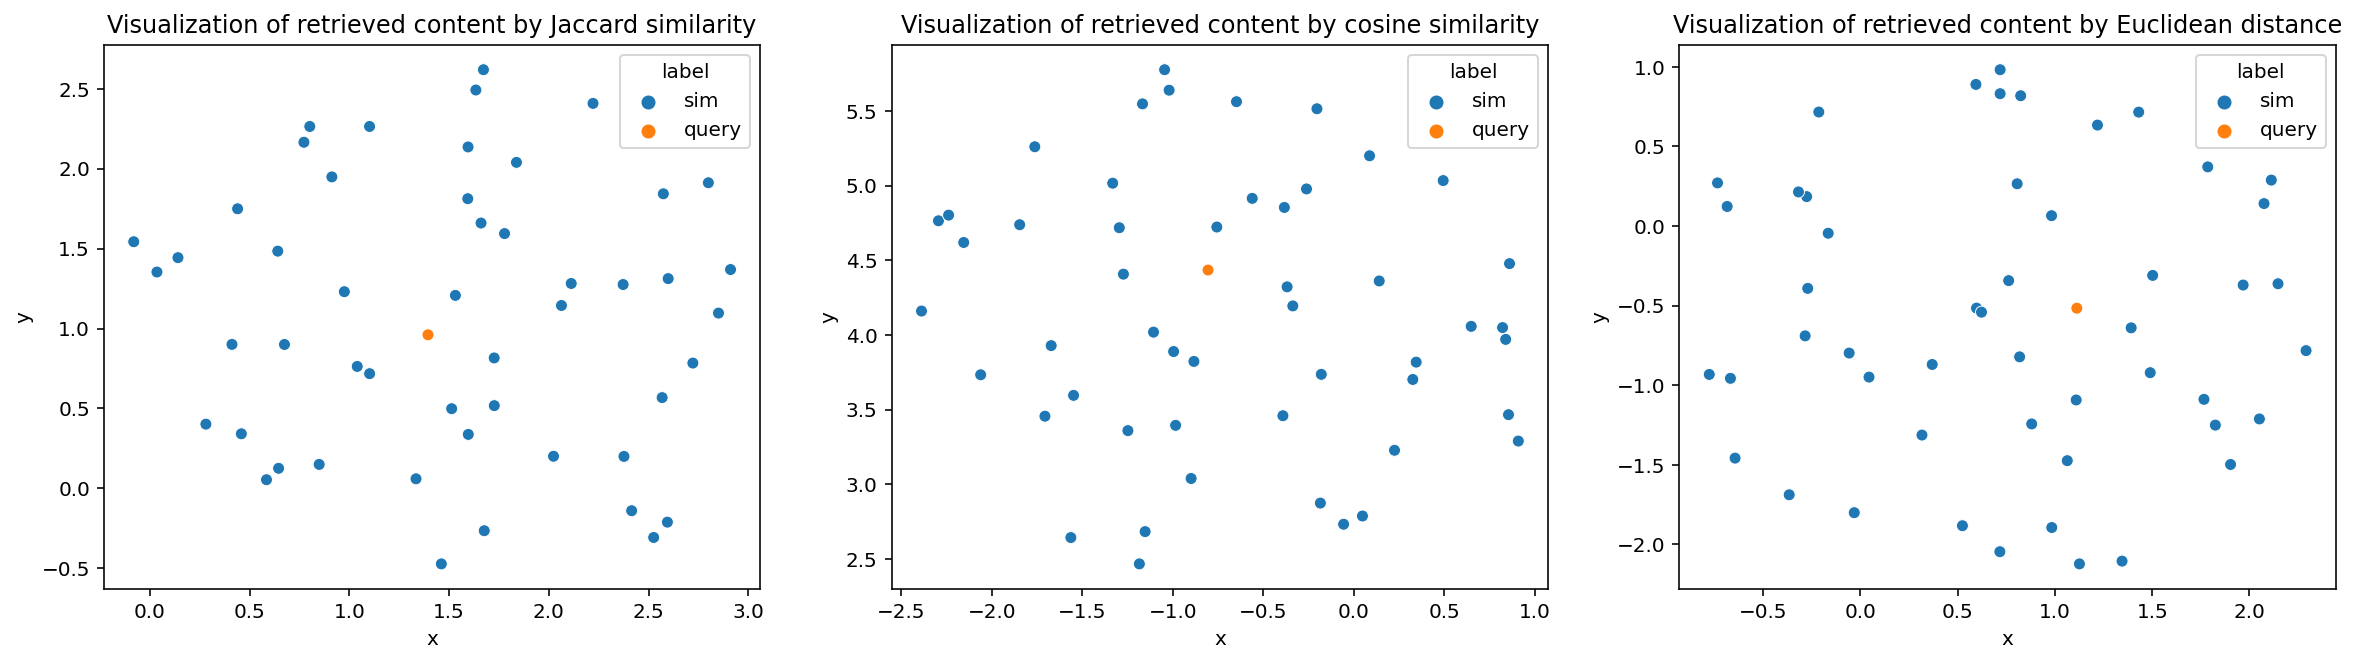

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (20,5)

df_j = pd.DataFrame(emb_j, columns=['x','y'])
df_j['label'] = label
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_j, hue='label', x='x', y='y')
plt.title("Visualization of retrieved content by Jaccard similarity")

df_c = pd.DataFrame(emb_c, columns=['x','y'])
df_c['label'] = label
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_c, hue='label', x='x', y='y')
plt.title("Visualization of retrieved content by cosine similarity")

df_e = pd.DataFrame(emb_e, columns=['x','y'])
df_e['label'] = label
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_e, hue='label', x='x', y='y')
plt.title("Visualization of retrieved content by Euclidean distance")

plt.show()